# Work for Tom Sargent
By Brandon Kaplowitz

Date: June 1, 2018 

## Problem 1.1 from "Marching Orders"
### Description of the Problem
We take from 0 to T $$y_t=\theta_ty_{t-1} + \varepsilon_t$$ $$ \theta_{t} = \theta_{t-1}+\nu_t $$
where  
$$
\begin{equation}
\left(\begin{matrix}
\varepsilon_t \\
\nu_t 
\end{matrix}\right) \sim \mathcal{N}\left(0,V\right) \ \text{and}  \ V= \left[ \begin{matrix} 
R & C \\
C & Q 
\end{matrix}\right].
\end{equation}
$$
We suppose initial state $\theta_0$ and $V$ are independent and their natural conjugate priors are
 $$\theta_0 \sim \mathbb{1}_{|\theta|<1}\mathcal{N}\left(\bar{\theta},\bar{P}\right) $$
 and 
 $$ V\sim \mathcal{IW}\left(\bar{V}^{-1}, T_0\right)$$ 
 where $\mathcal{IW}\left(S,df\right)$ is the inverse wishart distribution with scale matrix $S$ and degrees of freedom $df$. We suppose that $\left(\bar{\theta}, \bar{P}, \bar{V}^{-1} , T_0\right)$ are known and fixed.
 
 We  treat $\theta_t$ as a hidden state variable following a driftless random walk with the truncated Gaussian distribution:
 
 $$p\left(\theta_{t+1}|\theta_t,V\right) \propto \mathbb{1}_{|\theta_{t+1}| <1} \mathcal{N}\left(\theta_t,Q\right).$$
 
### Description of Algorithm

To solve this problem, we need to take the priors $\theta_0 \sim \mathbb{1}_{|\theta|<1}\mathcal{N}\left(\bar{\theta}, \bar{P}\right)$ and $V \sim \mathcal{IW}\left(\bar{V}^{-1}, T_0\right)$ and multiply them by their likelihoods to find their posteriors. The posterior is $$p\left(\theta^T,V|y^T\right) \underbrace{=}_{\text{By Bayes' Rule}} \frac{p\left(y^T|\theta^T,V\right)p\left(\theta^T,V\right)}{p\left(y^T\right)}= \frac{p\left(y^T|\theta^T,V
\right)p\left(\theta^T|V\right)p\left(V\right)}{p\left(y^T\right)}$$
$$ =\frac{\prod_{t=1}^{T}p\left(y_t|y_{t-1},\theta^T,V\right)\prod_{t=1}^{T}p\left(\theta_{t+1}|\theta_{t},V\right)p\left(\theta_0\right)p\left(V\right)}{p\left(y^T\right)} $$
We can see now that the first term is the likelihood, the second the Bayesian updating of $\theta$ from a prior on $\theta$ to a posterior on $\theta_t$ given the $\theta$ before it, and the last two terms the prior for $\theta_0$ and $V$. 
Note that: $$p\left(y_t|y_{t-1}, \theta^T,V\right)=  p\left(\theta_t y_{t-1}+\varepsilon_t|\theta_t, y_{t-1},\varepsilon_{t-1} \right)\underbrace{=}_{iid}p\left(\varepsilon_t\right) \sim \mathcal{N}\left(\theta_t y_{t-1},R\right)$$
$$p\left(\theta_{t+1} | \theta_{t},V\right) \propto \mathbb{1}_{|\theta_{t+1}|<1}\mathcal{N}\left(\theta_t,Q\right)$$

The procedure we use is as follows. We use a modification to MCMC called HMC, as well as the Metropolis-Hastings for speed comparison. We compute the numerator of the fraction given above to give a conditional pdf. We then take a proposal distribution, draw a new point from the proposal. If the ratio of the numerator of the new point to the old point is greater than 1 we accept. Otherwise we accept with the probability of the ratio times a correction for asymmetric distributions. We can ignore the denominator as we are examining the ratio of two pdfs, both of which will have the same denominator, which is a normalization.
We now implement this procedure in PYMC3.
## Implementation

To actually implement this model, since $p(y_t|y_{t-1},\theta^T,V)$ is incredibly difficult to calculate explicitly, we will use the built in Hierarchical GLM modeller in PYMC3. 

The model we will use looks as follows:

![title](Source.gv.png)

In [1]:
%reset -f
%pylab inline
import pymc3 as pm
import numpy as np
import matplotlib
from matplotlib import rc
import seaborn as sns
import theano as theano
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans']})
matplotlib.rcParams['mathtext.fontset'] = 'stixsans'
import matplotlib.pylab as plt 
plt.rc('mathtext', fontset="cm")
import scipy.stats as st
from pymc3.distributions import Continuous, Normal, MvNormal
import theano.tensor as tt
from theano import scan
from pymc3.util import get_variable_name
from pymc3.distributions.continuous import get_tau_sd, Normal, Flat
from pymc3.distributions.dist_math import Cholesky
from pymc3.distributions import multivariate
from pymc3.distributions import distribution
matplotlib.rcParams['font.sans-serif']='DejaVu Sans'
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
plt.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


/Users/bkaplowitz-local/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
T=50
theta_true=np.empty([T+1,1])
y_obs=np.empty([T+1,1])
theta_true[0]=st.norm.rvs(loc=.3,scale=.2)
while (theta_true[0]>1 or theta_true[0]<-1):
    theta_true[0]=st.norm.rvs(loc=.3,scale=.2)
errs=st.multivariate_normal.rvs(mean=[0,0], cov=[[0.4, 0.3], [0.3, 0.5]], size=T+1)
nu=errs[:,0]
err=errs[:,1]
y_obs[0]=err[0]
for t in range(1,T+1):
    theta_true[t]=theta_true[t-1]+nu[t]
    while (theta_true[t]>1 or theta_true[t]<-1):
        theta_true[t]=st.norm.rvs(loc=theta_true[t-1], scale=np.sqrt(.5))
    y_obs[t]= theta_true[t]*y_obs[t-1]+err[t]
#fix constant values.

[[-0.52275186]
 [ 1.19857277]
 [ 1.80081851]
 [ 0.90812434]
 [-0.05672817]
 [-0.71980093]
 [ 0.49765464]
 [ 0.62356417]
 [ 0.26964384]
 [-1.50469437]
 [-0.08545297]
 [-0.31228854]
 [-1.28844449]
 [-1.17885992]
 [-1.69786716]
 [-0.76456199]
 [ 0.73751681]
 [-0.31065195]
 [-0.10413099]
 [-0.75109084]
 [-0.08208491]
 [ 0.20839949]
 [-0.88770526]
 [-0.83459253]
 [-0.25099698]
 [-0.64085474]
 [ 0.37879056]
 [ 0.77141247]
 [ 1.28459894]
 [ 1.32849104]
 [ 2.45480936]
 [-3.10643971]
 [ 1.2642918 ]
 [-0.98657811]
 [ 0.32508038]
 [-0.25199804]
 [ 0.2262034 ]
 [ 0.80979071]
 [-1.33102256]
 [-0.50737974]
 [-1.20271919]
 [-0.50253489]
 [ 0.20651757]
 [ 0.51031039]
 [ 0.43316189]
 [ 1.54699557]
 [ 0.13809301]
 [ 0.39680368]
 [-1.05838467]
 [-0.33103543]
 [-0.85468527]]
[[ 0.06784115]
 [ 0.382268  ]
 [ 0.73384229]
 [ 0.23293242]
 [ 0.87709053]
 [-0.26774918]
 [-0.36792384]
 [ 0.11549261]
 [ 0.42446344]
 [-0.50719557]
 [ 0.79699047]
 [-0.05370661]
 [ 0.46701627]
 [ 0.91229577]
 [ 0.74234921]
 [ 0.4542

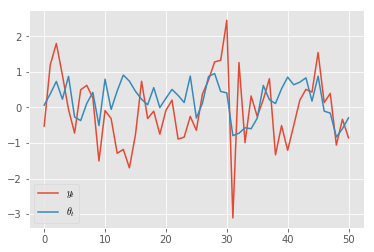

In [3]:
plt.plot(y_obs, label=r'$y_t$') 
plt.plot(theta_true,label=r'$\theta_t$')
print(y_obs)
print(theta_true)
plt.legend()

In [30]:
#define the likelihood function used
#TODO: Add random variable component that can be called to generate posterior predictive.
class univautoreg(Continuous):
    def __init__(self,theta0=None, v=None, *args, **kwargs):
        super(univautoreg, self).__init__(*args, **kwargs)
        self.theta0 = theta0
        self.mean = tt.as_tensor_variable(0.)
        self.v=v
    def logp(self,value):
        theta0=self.theta0
        v=self.v
        theta=theta0.flatten()
        valuenew=value.flatten()
        #append 0 and 0 as '-1' conditions so that calculations of initial errors are done corretly
        #consider doing tensor version of this to speed up
        def calc_next_err(value,last_value,theta_t,theta_last,vin): #calculates next perior error epsilon_t, nu_t
            this_period=pm.math.stack([value,theta_t],axis=0)
            meanval=theta_t*last_value
            last_period=pm.math.stack([meanval,theta_last],axis=0)
            err=this_period-last_period
            errnew=err.reshape([2,1])
            lik= MvNormal.dist(mu=np.zeros(2), cov=vin).logp(errnew) #likelihood of each is from multivariate normal #check if possible misspecification here
            return lik
        err_like, _  = scan(fn=calc_next_err,
                         sequences=[dict(input=valuenew, taps=[0,-1]),dict(input=theta, taps=[0,-1])],
                         outputs_info=[None],
                         non_sequences=[v]
                        )
        liketotal=tt.sum(err_like)
        return (liketotal)

In [33]:
#Parameters needed to make model work.
theta_bar = .5
P_bar = 4
P_bar_sd = np.sqrt(P_bar)
V_bar = [[2,3],[3,4]]
T_0 =.2
with pm.Model() as model1:
    #Variance function
    BoundedNorm = pm.Bound(pm.Normal,lower=-1.0,upper=1.0) #defines bounded normal
    BoundedGRW = pm.Bound(pm.GaussianRandomWalk, lower=-1.0, upper=1.0) #defines bounded gaussian random walk
    packed_cov = pm.LKJCholeskyCov('chol_cov', n=2, eta=2, sd_dist=pm.HalfCauchy.dist(beta=1.5,shape=2)) #equivalent of p(V), gives prior on cholesky of COV
    chol = pm.expand_packed_triangular(2,packed_cov, lower=True) #generates cholesky decomp. from packed triangular matrix in previous problem
    v=pm.Deterministic('v',tt.dot(chol,chol.T)) #generates cov matrix from cholesky decomposition
    sdtemp=tt.sqrt(tt.diag(v)) #takes sqrt of each variance to get sd
    sd = sdtemp[1] #recovers sd
    #Theta prior
    thetainit=BoundedNorm.dist(mu=theta_bar,sd=P_bar_sd,transform=False)
    #Theta Updating Process
    theta=BoundedGRW('theta', sd=sd, init=thetainit, shape=len(y_obs)) #gives prior on sequence of thetas
    #Likelihood function
    like = univautoreg('like', theta0=theta, v=v, observed=y_obs) #specifies model from class
    step =pm.Metropolis() #sets type of model
    start= pm.find_MAP() #see if I can figure out why it is generating NA or inf here.
    tracemodel1 = pm.sample(tune=200000,cores=4, samples=20000,step=step) #runs sample on posterior

logp = 2,179.8, ||grad|| = 4.1381e+05: 100%|██████████| 138/138 [00:02<00:00, 51.53it/s] 
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [theta_interval__]
>Metropolis: [chol_cov_cholesky_cov_packed__]
100%|██████████| 200500/200500 [33:56<00:00, 98.45it/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [32]:
pm.summary(tracemodel1)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
chol_cov__0,0.144768,0.015680,0.001565,0.132603,0.178401,3.208608,2.075423
chol_cov__1,0.122848,0.009059,0.000895,0.102000,0.132629,3.316589,1.925510
chol_cov__2,0.047051,0.018844,0.001884,0.030946,0.089480,2.360058,3.289281
v__0_0,0.021204,0.005097,0.000509,0.017584,0.031827,3.534164,1.900196
v__0_1,0.017651,0.000646,0.000059,0.016618,0.019055,4.809683,1.422203
v__1_0,0.017651,0.000646,0.000059,0.016618,0.019055,4.809683,1.422203
v__1_1,0.017743,0.000645,0.000056,0.016784,0.019330,4.889216,1.417709
theta__0,0.138004,0.047431,0.004727,0.067763,0.208918,2.188062,3.978436
theta__1,0.136945,0.050675,0.005055,0.067705,0.219746,2.136488,4.606644
theta__2,0.156799,0.047244,0.004710,0.104833,0.244017,2.127404,4.704977


In [12]:
pm.hpd(tracemodel1)

{0: {'chol_cov_cholesky_cov_packed__': array([[-1.97251456, -1.93676579],
         [ 0.12898277,  0.13374031],
         [-3.37603551, -3.27799116]]),
  'theta_interval__': array([[ 0.26034293,  0.36836311],
         [ 0.24940958,  0.31198746],
         [ 0.28402766,  0.33132251],
         [ 0.2103923 ,  0.33102438],
         [ 0.14397862,  0.27182433],
         [ 0.14618691,  0.21303343],
         [ 0.13257679,  0.18437875],
         [ 0.09404411,  0.19627993],
         [ 0.1053787 ,  0.20141785],
         [ 0.08845833,  0.19950079],
         [ 0.1503735 ,  0.22279685],
         [ 0.20752898,  0.31165317],
         [ 0.30433621,  0.36102561],
         [ 0.35095112,  0.42278363],
         [ 0.37738229,  0.4270815 ],
         [ 0.30580682,  0.37943952],
         [ 0.24702474,  0.31344593],
         [ 0.17882648,  0.27514049],
         [ 0.17268096,  0.24917317],
         [ 0.15418271,  0.21569658],
         [ 0.14318219,  0.21462991],
         [ 0.04702957,  0.17544429],
         [ 0.048

In [13]:
pm.quantiles(tracemodel1)

{0: {'chol_cov_cholesky_cov_packed__': {2.5: array([-1.97532048,  0.12913421, -3.37913684]),
   25: array([-1.96130642,  0.13030098, -3.36779362]),
   50: array([-1.95560108,  0.13186335, -3.33530419]),
   75: array([-1.95065394,  0.13255259, -3.30205933]),
   97.5: array([-1.93867687,  0.13465455, -3.27799116])},
  'theta_interval__': {2.5: array([ 0.25982791,  0.24698386,  0.27664043,  0.2073217 ,  0.14397862,
           0.14618691,  0.1234773 ,  0.09215909,  0.1053787 ,  0.09661952,
           0.14647215,  0.20083268,  0.3024808 ,  0.34429557,  0.37842522,
           0.30580682,  0.25048407,  0.18087281,  0.18206095,  0.15065854,
           0.14183117,  0.041071  ,  0.04172696,  0.02810101,  0.01458932,
           0.01921668,  0.00515904,  0.02727515,  0.01057364, -0.03302892,
          -0.15056788, -0.44078544, -0.48659522, -0.50643267, -0.43774324,
          -0.38965799, -0.3223004 , -0.24108542, -0.2114288 , -0.12544505,
          -0.09227019, -0.05083719, -0.01673413,  0.0228740

array([[<matplotlib.axes._subplots.AxesSubplot object at 0xa3153fa90>,
      dtype=object)

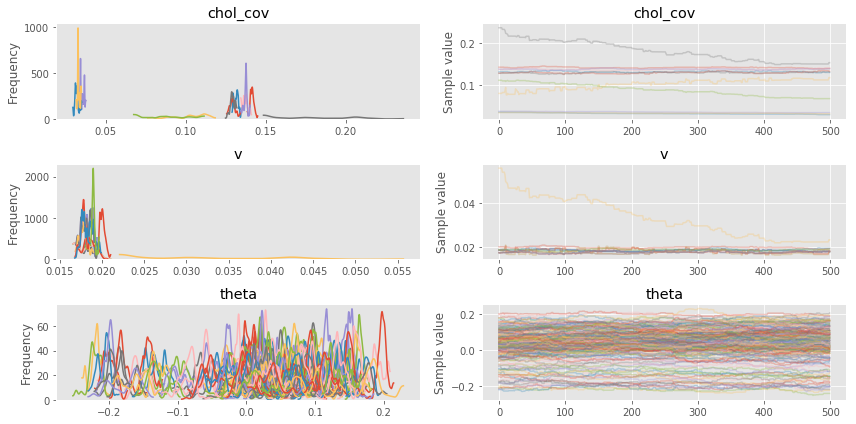

In [14]:
pm.traceplot(tracemodel1[:], alpha=.3)

ValueError: object too deep for desired array

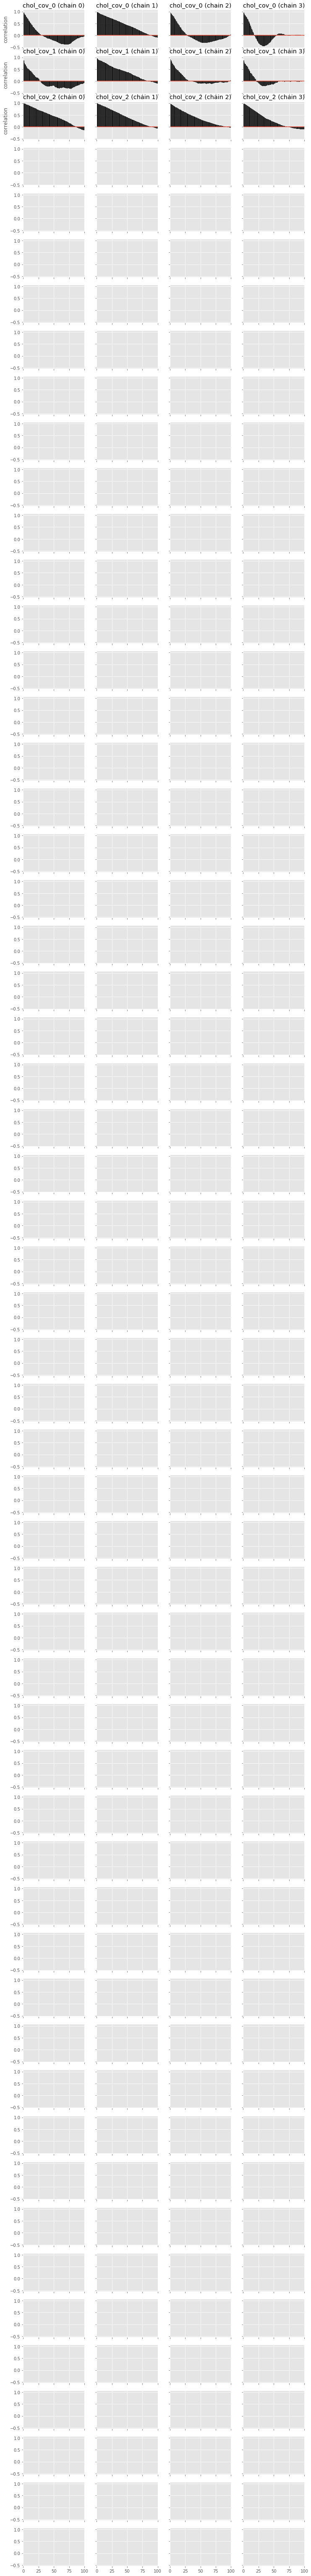

In [15]:
pm.autocorrplot(tracemodel1[0::2])

ValueError: too many values to unpack (expected 2)

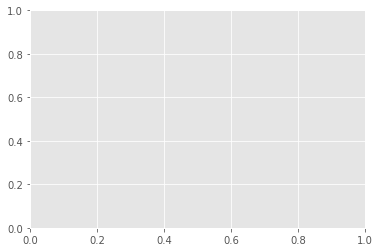

In [35]:
sns.kdeplot(tracemodel1[::2]['theta'])

/Users/bkaplowitz-local/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:645: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)


ValueError: cannot reshape array of size 4000 into shape (2,2)

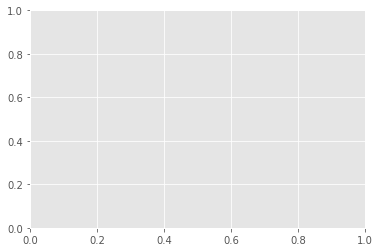

In [17]:
sns.kdeplot(tracemodel1[::2]['v'])

In [18]:
model1.vars

[chol_cov_cholesky_cov_packed__, theta_interval__]

In [26]:
model1.deterministics
#postpred= pm.sample_ppc(tracemodel1,samples=500, model=model1, size=100)

  0%|          | 0/500 [00:00<?, ?it/s]


AttributeError: 'univautoreg' object has no attribute 'random'

In [20]:
plt.hist(postpred['like'], alpha=0.2, normed=True)
sns.kdeplot(tr1['mu']);

NameError: name 'postpred' is not defined